# ANLP Assignment (Autumn 2020)

For assessment, you are expected to complete and submit this notebook file. When answers require code, you may import and use library functions (unless explicitly told otherwise). All of your own code should be included in the notebook rather than imported from elsewhere. Written answers should also be included in the notebook. You should insert as many extra cells as you want and change the type between code and markdown as appropriate.

In order to avoid misconduct, you should not talk about the assignment questions with your peers. If you are not sure what a question is asking you to do or have any other questions, please ask me or one of the Teaching Assistants.

Marking guidelines are provided as a separate document.

The first few cells contain code to set-up the assignment and bring in some data. In order to provide unique datasets for analysis by different students, you must enter your candidate number in the following cell. Otherwise do not change the code in these cells.



In [1]:
candidateno=253176 # this MUST be updated to your candidate number so that you get a unique data sample

In [2]:
#set up drives for resources.  Change the path as necessary
from google.colab import drive

# mount google drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
import sys
sys.path.append('/content/drive/MyDrive/')#NLE Notebooks/resources/
sys.path

['',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/drive/MyDrive/']

In [4]:
# do not change the code in this cell
# preliminary imports

import re
import random
import math
import pandas as pd
import matplotlib.pyplot as plt
from itertools import zip_longest

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('wordnet_ic')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.corpus import wordnet as wn
from nltk.corpus import wordnet_ic as wn_ic
brown_ic = wn_ic.ic("ic-brown.dat")
from sussex_nltk.corpus_readers import AmazonReviewCorpusReader
from sussex_nltk.corpus_readers import ReutersCorpusReader

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet_ic to /root/nltk_data...
[nltk_data]   Package wordnet_ic is already up-to-date!


Sussex NLTK root directory is /content/drive/MyDrive


# Question 1: Books vs DVDs

In this question, you will be investigating NLP methods for distinguishing reviews written about books from reviews written about DVDs.

In [ ]:
#do not change the code in this cell
def split_data(data, ratio=0.7): # when the second argument is not given, it defaults to 0.7
    """
    Given corpus generator and ratio:
     - partitions the corpus into training data and test data, where the proportion in train is ratio,

    :param data: A corpus generator.
    :param ratio: The proportion of training documents (default 0.7)
    :return: a pair (tuple) of lists where the first element of the 
            pair is a list of the training data and the second is a list of the test data.
    """
    
    data = list(data)  
    n = len(data)  
    train_indices = random.sample(range(n), int(n * ratio))          
    test_indices = list(set(range(n)) - set(train_indices))    
    train = [data[i] for i in train_indices]           
    test = [data[i] for i in test_indices]             
    return (train, test)                       
 

def feature_extract(review):
    """
    Generate a feature representation for a review
    :param review: AmazonReview object
    :return: dictionary of Boolean features
    """
    return {word:True for word in review.words()}

def get_training_test_data(categories=('book','dvd'),ratio=0.7,seed=candidateno):
    """
    Get training and test data for a given pair of categories and ratio, pre-formatted for use with NB classifier
    :param category: pair of categories of review corpus, two from ["kitchen, "dvd, "book", "electronics"]
    :param ratio: proportion of data to use as training data
    :return: pair of lists 
    """
    random.seed(candidateno)

    train_data=[]
    test_data=[]
    for category in categories:
      reader=AmazonReviewCorpusReader().category(category)    
      train, test = split_data(reader.documents(),ratio=ratio)
   
      train_data+=[(feature_extract(review),category)for review in train]
      test_data+=[(feature_extract(review),category)for review in test]
    random.shuffle(train_data)
    random.shuffle(test_data)

    return train_data,test_data

When you have run the cell below, your unique training and testing samples will be stored in `training_data` and `testing_data`

In [ ]:
#do not change the code in this cell
training_data,testing_data=get_training_test_data()
print("The amount of training data is {}".format(len(training_data)))
print("The amount of testing data is {}".format(len(testing_data)))
print("The representation of a single data item is below")
print(training_data[0])

The amount of training data is 6526
The amount of testing data is 2799
The representation of a single data item is below
({'I': True, 'agree': True, 'with': True, 'a': True, 'previous': True, 'reviewer': True, 'who': True, 'found': True, 'fault': True, 'the': True, 'way': True, 'story': True, 'was': True, 'told': True, '.': True, 'There': True, 'is': True, 'no': True, 'excitement': True, 'in': True, 'describing': True, 'stages': True, 'They': True, 'are': True, 'just': True, 'wrapped': True, 'up': True, 'all': True, 'of': True, 'sudden': True, 'To': True, 'me': True, ',': True, 'it': True, 'did': True, 'not': True, 'seem': True, 'like': True, 'author': True, 'many': True, 'interviews': True, 'his': True, 'own': True, 'It': True, 'seems': True, 'he': True, 'watched': True, 'Tour': True, 'de': True, 'France': True, 'and': True, 'retold': True, 'what': True, 'saw': True, 'on': True, 'broadcast': True, 'His': True, 'supposed': True, '``': True, 'back-stories': True, 'which': True, 'should'

a) Use your training data to find
i) the top 20 words which occur more frequently in book reviews than in dvd reviews
ii) the top 20 words which occur more frequently in dvd reviews than book reviews
Discuss what pre-processing techniques you have applied (or not applied) in answering this question, and why. [10 marks]

In [ ]:
#Get the words for each tag
book_data=[]
dvd_data=[]

for data in training_data:
  if data[1]=="book":
    book_data+=data[0]
  if data[1]=="dvd":
    dvd_data+=data[0]


In [ ]:
from nltk.corpus import stopwords
from collections import Counter
nltk.download('stopwords')
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def most_frequent_words(firstfreq,secondfreq,topk):
    difference=[(w,f-secondfreq.get(w,0)) for (w,f) in firstfreq.most_common()]
    sorteddiff=sorted(difference,key=lambda pair:pair[1],reverse=True)
    normalised=[w.lower() for (w,f) in sorteddiff]
    filtered=[w for w in normalised if w.isalpha() and w not in stop]
    return filtered[:topk]

top_dvd=most_frequent_words(Counter(dvd_data),Counter(book_data),20)
top_book=most_frequent_words(Counter(book_data),Counter(dvd_data),20)
print(top_dvd)
print(top_book)

['movie', 'film', 'dvd', 'watch', 'one', 'see', 'great', 'movies', 'like', 'good', 'seen', 'watching', 'films', 'really', 'get', 'show', 'scenes', 'acting', 'love', 'time']
['book', 'read', 'books', 'reading', 'author', 'reader', 'writing', 'written', 'pages', 'novel', 'information', 'readers', 'page', 'authors', 'chapter', 'novels', 'write', 'chapters', 'published', 'ideas']


The **pre-processing techniques** I have applied:



1.   **case normalisation**: converting all of the text into lower case;
2.   **punctuation and stop-word removal**: A stopword is a word that occurs so often that it loses its usefulness in some tasks. We may get more meaningful information from our corpus analysis if we remove stopwords and punctuation.





   ----

b) Design, build and test a word list classifier to classify reviews as being from the book domain or from the dvd domain.  Make sure you discuss i) how you decide the lengths and contents of the word lists and ii) accuracy, precision and recall of your final classifier.[15 marks]

**How I decide the length of the word lists**:
- I'd like to use the `check_expectations` method to do a test

In [ ]:
def check_expectations(a_word_list,expectation,pos_freqdist=Counter(book_data),neg_freqdist=Counter(dvd_data)):
#expectation is a positive number if words are expected to be positive
#expectation is a negative number if words are expected to be negative

    for word in a_word_list:
        pos_freq=pos_freqdist.get(word,0)
        neg_freq=neg_freqdist.get(word,0)
        diff=pos_freq-neg_freq
        if diff*expectation>0:
            print("As expected: for {} difference is {}".format(word,diff))
        else:
            print("Contrary to expectations: for {} difference is {}".format(word,diff))
check_expectations(top_book[:6],1)
check_expectations(top_dvd[:6],-1)

As expected: for book difference is 1867
As expected: for read difference is 931
As expected: for books difference is 506
As expected: for reading difference is 442
As expected: for author difference is 395
As expected: for reader difference is 238
As expected: for movie difference is -1657
As expected: for film difference is -1214
As expected: for dvd difference is -146
As expected: for watch difference is -656
As expected: for one difference is -562
As expected: for see difference is -526


**How I decide the contents of the word lists**:
- the words I expected to indicate book's sentiment actually occur more frequently in books reviews than dvds reviews
- the words I expected to indicate dvd's sentiment actually occur more frequently in dvds reviews than books reviews.
- So I use the most_common method to return a list of word as the word lists

In [ ]:
from nltk.classify.api import ClassifierI
import random

class SimpleClassifier(ClassifierI): 
    def __init__(self, pos, neg): 
        self._pos = pos 
        self._neg = neg 
    def classify(self, words): 
        score = 0
        for word in words:
          if word in self._pos:
            score+=1
          if word in self._neg:
            score-=1
        
        return "dvd" if score < 0 else "book"
    def classify_many(self, docs): 
        return [self.classify(doc.words() if hasattr(doc, 'words') else doc) for doc in docs] 
    def labels(self): 
        return ("book", "dvd")

class SimpleClassifier_mf(SimpleClassifier):  
    def __init__(self,k):
        self._k=k 
    def train(self,book_data,dvd_data):
        pos_freqdist = Counter(book_data)
        neg_freqdist = Counter(dvd_data)
        self._pos=most_frequent_words(pos_freqdist,neg_freqdist,self._k)
        self._neg=most_frequent_words(neg_freqdist,pos_freqdist,self._k)


In [ ]:
myclassifier=SimpleClassifier_mf(100)
myclassifier.train(book_data,dvd_data)
res_my = myclassifier.classify_many(training_data)
# print(res_my)

**ii) accuracy, precision and recall of your final classifier.**

In [ ]:
class ConfusionMatrix:
  def __init__(self,predictions,goldstandard,classes=("book","dvd")):   
    (self.c1,self.c2)=classes
    self.TP=0
    self.FP=0
    self.FN=0
    self.TN=0
    for p,g in zip(predictions,goldstandard):
        if g==self.c1:
            if p==self.c1:
                self.TP+=1
            else:
                self.FN+=1
        
        elif p==self.c1:
            self.FP+=1
        else:
            self.TN+=1
          
  def precision(self):
    #put your code to compute precision here
    p = self.TP / (self.TP + self.FP)
    return p
  
  def recall(self):
    #put your code to compute recall here
    r = self.TP / (self.TP + self.FN)
    return r
  
  def f1(self):
    #put your code to compute f1 here
    r = self.recall()
    p = self.precision()
    f1 = 2*r*p/(r + p)
    return f1 

In [ ]:
docs,goldstandard=zip(*testing_data)
predictions=myclassifier.classify_many(docs)
senti_cm=ConfusionMatrix(predictions,goldstandard)

**precision**

In [ ]:
senti_cm.precision()

0.884

**recall**

In [ ]:
senti_cm.recall()

0.3840139009556907

**f1**

In [ ]:
senti_cm.f1()

0.5354330708661417

---


c) Compare the performance of your word list classifier with a Naive Bayes classifier (e.g., from NLTK).  Make sure you discuss the results. [10 marks]

In [ ]:
class NBClassifier:
    
    def __init__(self):   
        pass
    
    def _set_known_vocabulary(self,training_data):
        known=[]
        for doc,label in training_data:
            known+=list(doc.keys())
        self.known= set(known)
    
    def _set_priors(self,training_data):
        priors={}
        for (doc,label) in training_data:
            priors[label]=priors.get(label,0)+1
        total=sum(priors.values())
        for key,value in priors.items():
            priors[key]=value/total
        self.priors=priors
        
    def _set_cond_probs(self,training_data):       
        conds={}
        for(doc,label) in training_data:
            classcond=conds.get(label,{})
            for word in doc.keys():
                classcond[word]=classcond.get(word,0)+1
            conds[label]=classcond
    
        for label, classcond in conds.items():
            for word in self.known:
                classcond[word]=classcond.get(word,0)+1
            conds[label]=classcond
            
        for label,dist in conds.items():
            total=sum(dist.values())
            conds[label]={key:value/total for (key,value) in dist.items()}
        
        self.conds=conds
    
    def train(self,training_data):
        self._set_known_vocabulary(training_data)
        self._set_priors(training_data)
        self._set_cond_probs(training_data)
    
    def classify(self,doc):
        doc_probs={key:math.log(value) for (key,value) in self.priors.items()}
        for word in doc.keys():
            if word in self.known:
                doc_probs={classlabel:sofar+math.log(self.conds[classlabel].get(word,0)) for (classlabel,sofar) in doc_probs.items()}

        highprob=max(doc_probs.values())
        classes=[c for c in doc_probs.keys() if doc_probs[c]==highprob]
        return random.choice(classes)
    
    def classify_many(self,docs):
        return [self.classify(doc) for doc in docs]

In [ ]:
NBclassifier=NBClassifier()
NBclassifier.train(training_data)
res_bayes = NBclassifier.classify_many(doc for (doc,label) in testing_data)

In [ ]:
predictions2=NBclassifier.classify_many(docs)
senti_cm2=ConfusionMatrix(predictions2,goldstandard)

In [ ]:
def evaluate_wordlist_classifier(classifier, testing_data):
    docs,goldstandard=zip(*testing_data) #note this neat pythonic way of turning a list of pairs into a pair of lists
    predictions=classifier.classify_many(docs)
    #print(predictions)
    correct=0
    for (prediction,gold) in zip(predictions,goldstandard):
        if prediction ==gold:
            correct+=1
    return correct/len(testing_data)

score1=evaluate_wordlist_classifier(myclassifier, testing_data)
score2=evaluate_wordlist_classifier(NBclassifier, testing_data)


In [ ]:
print("The accuracy of myclassifier: " + str(score1))
print("The accuracy of NBclassifier: " + str(score2))
print("The precision of myclassifier: " + str(senti_cm.precision()))
print("The precision of NBclassifier: " + str(senti_cm2.precision()))
print("The recall of myclassifier: " + str(senti_cm.recall()))
print("The recall of NBclassifier: " + str(senti_cm2.recall()))
print("The f1-score of myclassifier: " + str(senti_cm.f1()))
print("The f1-score of NBclassifier: " + str(senti_cm2.f1()))

The accuracy of myclassifier: 0.7259735619864237
The accuracy of NBclassifier: 0.9371204001429082
The precision of myclassifier: 0.884
The precision of NBclassifier: 0.9468377635197067
The recall of myclassifier: 0.3840139009556907
The recall of NBclassifier: 0.89748045178106
The f1-score of myclassifier: 0.5354330708661417
The f1-score of NBclassifier: 0.9214986619090099


**Discussing the results.**

As can be seen from the above comparison, the accuracy and recall of the Bayesian classifier are greater than that of the self-built classifier, so in the current situation, the performance of the Bayesian classifier is better.

---


d) Design and carry out an experiment into the impact of the amount of training data on each of these classifiers. Make sure you describe design decisions in your experiment, include a graph of your results and discuss your conclusions. [15 marks]

**Design decisions:**
-  Use the following sample sizes 1, 50, 500 
-  Use the sample function from the random module to compare the performance change on two classifiers on datasets of different sizes
-  Use a Pandas dataframe to display the results in a table and graph

In [ ]:
from random import sample
word_list_size = 100

classifiers={"Word List":SimpleClassifier_mf(word_list_size),
             "Naive Bayes":NBClassifier()}
use=["Word List","Naive Bayes"]
sample_sizes=[1,50,500]
number_of_runs=1
results={}


for size in sample_sizes:
  results[size]=[]

  for c in use:
    results[size].append(0)
  for i in range(number_of_runs):
    training_data,testing_data=get_training_test_data()
    training_sample=sample(training_data,size)
    res=[]
    for name,classifier in classifiers.items():
        if name in use:
            if name == "Word List":
              myclassifier=classifier
              myclassifier.train(sample(book_data,size),sample(dvd_data,size))
            else:
              myclassifier=classifier
              myclassifier.train(training_sample)
            accuracy=evaluate_wordlist_classifier(myclassifier,testing_data)
            print("The accuracy of {} classifier with training sample size {} is {}".format(name,size,accuracy))
            res.append(accuracy/number_of_runs)
    results[size]=[total+new for total,new in zip(results[size],res)]

results            
# df = pd.DataFrame(results,columns=["sample size","word list accuracy","NB accuracy"])
# display(df)

The accuracy of Word List classifier with training sample size 1 is 0.4287245444801715
The accuracy of Naive Bayes classifier with training sample size 1 is 0.41121829224723117
The accuracy of Word List classifier with training sample size 50 is 0.5537692032868882
The accuracy of Naive Bayes classifier with training sample size 50 is 0.796713111825652
The accuracy of Word List classifier with training sample size 500 is 0.6748838871025367
The accuracy of Naive Bayes classifier with training sample size 500 is 0.8363701321900678


{1: [0.4287245444801715, 0.41121829224723117],
 50: [0.5537692032868882, 0.796713111825652],
 500: [0.6748838871025367, 0.8363701321900678]}

In [ ]:
df=pd.DataFrame(results)
display(df)

,1,50,500
0,0.428725,0.553769,0.674884
1,0.411218,0.796713,0.836370


In [ ]:
df = pd.DataFrame(results).transpose()
df.columns=list(classifiers.keys())
display(df)

,Word List,Naive Bayes
1,0.428725,0.411218
50,0.553769,0.796713
500,0.674884,0.836370


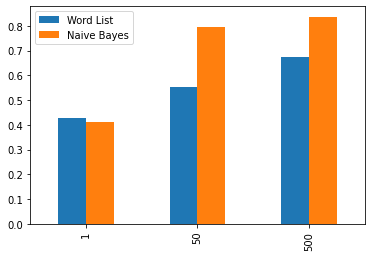

In [ ]:
ax=df.plot(kind="bar",y=["Word List","Naive Bayes"])

**Discuss my conclusions:**
- When the data is very small, the self-built classifier performs better
- The more data, the better the Bayesian classifier can be.

---


# Question 2: Distributional Semantics

In this question, you will be investigating the *distributional hypothesis*: **words which appear in similar contexts tend to have similar meanings**.

We are going to be using the Reuters corpus of financial documents for this part of the assignment.  When you run the following cell you should see that it contains 1,113,359 sentences.

In [5]:
#do not change the code in this cell
rcr = ReutersCorpusReader().finance()
rcr.enumerate_sents()

1113359

The following cell will take 2-5 minutes to run. It will generate a unique-to-you sample of 200,000 sentences. These sentences are tokenised and normalised for case and number for you.

In [6]:
#do not change the code in this cell
def normalise(tokenlist):
    tokenlist=[token.lower() for token in tokenlist]
    tokenlist=["NUM" if token.isdigit() else token for token in tokenlist]
    tokenlist=["Nth" if (token.endswith(("nd","st","th")) and token[:-2].isdigit()) else token for token in tokenlist]
    tokenlist=["NUM" if re.search("^[+-]?[0-9]+\.[0-9]",token) else token for token in tokenlist]
    return tokenlist

random.seed(candidateno)  
samplesize=2000
iterations =100
sentences=[]
for i in range(0,iterations):
    sentences+=[normalise(sent) for sent in rcr.sample_sents(samplesize=samplesize)]
    print("Completed {}%".format(i))
print("Completed 100%")

Completed 0%
Completed 1%
Completed 2%
Completed 3%
Completed 4%
Completed 5%
Completed 6%
Completed 7%
Completed 8%
Completed 9%
Completed 10%
Completed 11%
Completed 12%
Completed 13%
Completed 14%
Completed 15%
Completed 16%
Completed 17%
Completed 18%
Completed 19%
Completed 20%
Completed 21%
Completed 22%
Completed 23%
Completed 24%
Completed 25%
Completed 26%
Completed 27%
Completed 28%
Completed 29%
Completed 30%
Completed 31%
Completed 32%
Completed 33%
Completed 34%
Completed 35%
Completed 36%
Completed 37%
Completed 38%
Completed 39%
Completed 40%
Completed 41%
Completed 42%
Completed 43%
Completed 44%
Completed 45%
Completed 46%
Completed 47%
Completed 48%
Completed 49%
Completed 50%
Completed 51%
Completed 52%
Completed 53%
Completed 54%
Completed 55%
Completed 56%
Completed 57%
Completed 58%
Completed 59%
Completed 60%
Completed 61%
Completed 62%
Completed 63%
Completed 64%
Completed 65%
Completed 66%
Completed 67%
Completed 68%
Completed 69%
Completed 70%
Completed 71%
Co

In [7]:
print(len(sentences))
print(sentences[0])

200000
['russian', 'prime', 'minister', 'viktor', 'chernomyrdin', 'arrived', 'in', 'brussels', 'on', 'thursday', 'for', 'a', 'two-day', 'visit', 'to', 'seek', 'stronger', 'relations', 'with', 'the', 'european', 'union', 'a', 'day', 'after', 'the', '15-nation', 'bloc', 'named', 'the', 'six', 'states', 'it', 'hopes', 'to', 'bring', 'into', 'the', 'club', '.']


generate_features() will used and explored below.

In [8]:
# do not change the code in this cell
def generate_features(sentences,window=1):
    mydict={}
    for sentence in sentences:
        for i,token in enumerate(sentence):
            current=mydict.get(token,{})
            features=sentence[max(0,i-window):i]+sentence[i+1:i+window+1]
            for feature in features:
                current[feature]=current.get(feature,0)+1
            mydict[token]=current
    return mydict

a) Run `generate_features(sentences[:5])`. With reference to the code and the specific examples, explain how the output was generated [5 marks]

In [9]:
generate_features(sentences[:5])

{'.': {'NUM': 1, 'club': 1, 'deficit': 1, 'union': 1},
 '15-nation': {'bloc': 1, 'the': 1},
 'NUM': {'.': 1, 'budget': 1, 'expected': 1},
 'a': {'after': 1, 'day': 1, 'for': 1, 'special': 1, 'two-day': 1, 'union': 1},
 'after': {'a': 1, 'day': 1, 'said': 1, 'the': 1},
 'and': {'states': 1, 'the': 1},
 'arrived': {'chernomyrdin': 1, 'in': 1},
 'been': {'had': 1, 'made': 1},
 'between': {'negotiations': 1, 'the': 1},
 'bloc': {'15-nation': 1, 'named': 1},
 'bring': {'into': 1, 'to': 1},
 'brussels': {'in': 1, 'on': 1},
 'budget': {'NUM': 1, 'deficit': 1},
 'catherine': {'spokeswoman': 1, 'trautmann': 1},
 'chernomyrdin': {'arrived': 1, 'viktor': 1},
 'clinton': {'will': 1},
 'club': {'.': 1, 'the': 1},
 'continue': {'to': 1, 'will': 1},
 'day': {'a': 1, 'after': 1},
 'decisions': {'final': 1, 'had': 1},
 'deficit': {'.': 1, 'budget': 1},
 'during': {'negotiations': 1, 'provision': 1},
 'enforce': {'the': 1, 'to': 1},
 'european': {'the': 2, 'union': 2},
 'expected': {'NUM': 1, 'the': 1},

**Explain how the output was generated**
- We use a certain window around a target word as features of that word.
- the function generate_features which takes
  - a list of sentences (where each sentence is a list of tokens); 
  - and a window size;
- code execution flow 
  - loop through each sentence
  - iterate over the words in each sentence
  - record the words in the window position before and after the target word
  - record the frequency of these words in the dictionary
  - put the above dictionary into the dictionary with the current target word as the key

---

b) Write code and **find** the 1000 most frequently occurring words that
* are in your sample; AND
* have at least one noun sense according to WordNet [5 marks]

In [10]:
import operator
import nltk
from nltk.corpus import stopwords
from collections import Counter
nltk.download('stopwords')
stop = stopwords.words('english')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

### [target_word, word_synonym, word_definition]

In [11]:
from nltk.grammar import nonterminals
def freq_dist(sentences):
    mydict={}
    for sentence in sentences:
        for token in sentence:
            mydict[token]=mydict.get(token,0)+1
    return mydict

def most_frequent(freqdist,k=9999):
    return sorted(freqdist.items(),key=operator.itemgetter(1),reverse=True)[:k]
fre_words = most_frequent(freq_dist(sentences))
def normalise_words(fre_words,topk):
    normalised=[w.lower() for (w,f) in fre_words]
    filtered=[w for w in normalised if w.isalpha() and w not in stop]
    return filtered[:topk]
fre_words = normalise_words(fre_words,5000)
# print(len(fre_words))
fre_words_plus = []
sum=0
for wordA in fre_words:
  Synset_n=wn.synsets(wordA,wn.NOUN)
  for synset in Synset_n:
    for wordB in synset.lemma_names():
      if wordA!=wordB:
        fre_words_plus.append([wordA, wordB, synset.definition()])
        sum+=1
        break
    break
  if sum==1000:
    break
fre_words_plus


[['percent',
  'percentage',
  'a proportion in relation to a whole (which is usually the amount per hundred)'],
 ['pct',
  'percentage',
  'a proportion in relation to a whole (which is usually the amount per hundred)'],
 ['year', 'twelvemonth', 'a period of time containing 365 (or 366) days'],
 ['million',
  '1000000',
  'the number that is represented as a one followed by 6 zeros'],
 ['may', 'May', 'the month following April and preceding June'],
 ['government',
  'authorities',
  'the organization that is the governing authority of a political unit'],
 ['billion',
  'one_million_million',
  'the number that is represented as a one followed by 12 zeros; in the United Kingdom the usage followed in the United States is frequently seen'],
 ['uk',
  'United_Kingdom',
  "a monarchy in northwestern Europe occupying most of the British Isles; divided into England and Scotland and Wales and Northern Ireland; `Great Britain' is often used loosely to refer to the United Kingdom"],
 ['tax',
  

---

In [12]:
# do not change the code in this cell.  It relates to part c)
wordpair=("house","garden")
concept_1=wn.synsets(wordpair[0])[0]
concept_2=wn.synsets(wordpair[1])[0]
print("Path similarity between 1st sense of {} and 1st sense of {} is {}".format(wordpair[0],wordpair[1],wn.path_similarity(concept_1,concept_2)))
print("Resnik similarity between 1st sense of {} and 1st sense of {} is {}".format(wordpair[0],wordpair[1],wn.res_similarity(concept_1,concept_2, brown_ic)))
print("Lin similarity between 1st sense of {} and 1st sense of {} is {}".format(wordpair[0],wordpair[1],wn.lin_similarity(concept_1,concept_2, brown_ic)))

Path similarity between 1st sense of house and 1st sense of garden is 0.08333333333333333
Resnik similarity between 1st sense of house and 1st sense of garden is 1.2900256809649917
Lin similarity between 1st sense of house and 1st sense of garden is 0.15380807721262396


c) 
i) The code above outputs the path similarity score, the Resnik similarity score and the Lin similarity score for a pair of concepts in WordNet.  Explain what each of these numbers means.

ii) For every possible pair of words identified in Q2, determine the semantic similarity of the pair according to WordNet.  Make sure you justify your choice of semantic similarity measure and explain and justify the strategy used for words with multiple senses.

iii) Identify the 10 most similar words (according to WordNet) to the most frequent word in the corpus [15 marks]

**answer**

**i**)

- Path similarity：Judging the similarity of two words according to the path length in wordnet, and the value is 0.08333333333333333 
- Resnik similarity：A Resnik similarity measure is a lexical semantic similarity measure based on the information content of the least common subsumer, and the value is 1.2900256809649917  
- Lin similarity：A Lin Similarity Measureis a Node-based Semantic Similarity Measurethat is based on information contentof the least common subsumer, and the value is 0.15380807721262396

ii)  
-  I used the maximum similarity. The similarity of two words with a given part of speech is defined as the maximum similarity of all possible sense pairings.If word A has 5 noun senses and word B has 4 noun senses than there are 20 possible sense pairings to check.
-  And I generalised my path_similarity function so that it takes an extra optional argument.

In [13]:
def word_similarity(wordA,wordB,pos=wn.NOUN,measure="path"):
    synsetsA=wn.synsets(wordA,pos)
    synsetsB=wn.synsets(wordB,pos)
    maxsofar=0
    brown_ic=wn_ic.ic("ic-brown.dat")
    for synsetA in synsetsA:
        for synsetB in synsetsB:
            if measure=="path":
                sim=wn.path_similarity(synsetA,synsetB)
            elif measure=="res":
                sim=wn.res_similarity(synsetA,synsetB,brown_ic)
            elif measure=="lin":
                sim=wn.lin_similarity(synsetA,synsetB,brown_ic)
            
            if sim>maxsofar:
                maxsofar=sim
    return maxsofar

If I use 1000 data to do this experiment, my colab will crash because of too much computation, so I want to scale down the data and simulate using the first 20 words

In [16]:
wordpairs = fre_words_plus[:20]
# wordpair1 = wordpairs[0]
# wordpair2 = wordpairs[2]
scores=[]
# score = word_similarity(wordpair1[1],wordpair2[1])
# scores.append([score,[wordpair1[0],wordpair2[0]]])
# print(scores)
i=0
for wordpair1 in wordpairs:
  i+=1
  print("Completed {} words".format(i))
  for wordpair2 in wordpairs[i:]:
    if wordpair1!=wordpair2:
      score = word_similarity(wordpair1[1],wordpair2[1])
      scores.append([score,[wordpair1[0],wordpair2[0]]])

print(scores)


Completed 1 words
Completed 2 words
Completed 3 words
Completed 4 words
Completed 5 words
Completed 6 words
Completed 7 words
Completed 8 words
Completed 9 words
Completed 10 words
Completed 11 words
Completed 12 words
Completed 13 words
Completed 14 words
Completed 15 words
Completed 16 words
Completed 17 words
Completed 18 words
Completed 19 words
Completed 20 words
[[1.0, ['percent', 'pct']], [0.1111111111111111, ['percent', 'year']], [0.09090909090909091, ['percent', 'million']], [0.09090909090909091, ['percent', 'may']], [0.1, ['percent', 'government']], [0.09090909090909091, ['percent', 'billion']], [0.06666666666666667, ['percent', 'uk']], [0.14285714285714285, ['percent', 'tax']], [0.1, ['percent', 'growth']], [0.1111111111111111, ['percent', 'last']], [0.1, ['percent', 'first']], [0.07692307692307693, ['percent', 'central']], [0.1, ['percent', 'price']], [0.09090909090909091, ['percent', 'june']], [0.1, ['percent', 'market']], [0.1111111111111111, ['percent', 'union']], [0.090

**iii)**  
If I use 1000 data to do this experiment, my colab will crash because of too much computation. So sorry I want to skip this topic

---

d)
i) Write code to construct distributional vector representations of words in the corpus with a parameter to specify context size.  Explain how you calculate the value of association between each word and each context feature.

ii) Use your code to construct representations of the 1000 words identified in Q2 with a window size of 1 and thus determine the 10 words which are distributionally most similar to the most frequent word in the corpus. [10 marks]

**i)** 

- I used positive pointwise mutual information (PPMI) to establish how significant a given frequency of co-occurrence is. If player and tennis are both very common words then their co-occurring together 10 times may be insignificant.   
- In order to carry out this calculation, we need the frequency of the co-occurrence player and tennis, the total number of times player has occurred with any feature, the total number of times tennis has occurred as a feature and the grand total of all possible co-occurrences.
- This class calculates the PPMI value for each feature in each vector.
- And I used cosine similarity to compute the similarity between two word vectors.

In [ ]:
class word_vectors:
    def __init__(self,sentences,window=3):
        self.sentences=sentences
        self.window=window
        self.reps={}
        self.wordtotals={}
        self.feattotals={}
        self.generate_features()
        self.grandtotal=sum(self.wordtotals.values())
        self.convert_to_ppmi()
    
    def generate_features(self):
        for sentence in self.sentences:
            for i,token in enumerate(sentence):
                current=self.reps.get(token,{})
                features=sentence[max(0,i-self.window):i]+sentence[i+1:i+self.window+1]
                for feature in features:
                    current[feature]=current.get(feature,0)+1
                    self.feattotals[feature]=self.feattotals.get(feature,0)+1
                self.wordtotals[token]=self.wordtotals.get(token,0)+len(features)
                self.reps[token]=current

    def convert_to_ppmi(self):
        self.ppmi={word:{feat:max(0,math.log((freq*self.grandtotal)/(self.wordtotals[word]*self.feattotals[feat]),2)) for (feat,freq) in rep.items()} for (word,rep) in self.reps.items()}
    
    def similarity(self,word1,word2):
        rep1=self.ppmi.get(word1,{})
        rep2=self.ppmi.get(word2,{})
        return dot(rep1,rep2)/math.sqrt(dot(rep1,rep1)*dot(rep2,rep2))
    
    def nearest_neighbours(self,word1,n=1000,k=10):
        candidates=sorted(self.wordtotals.items(),key=operator.itemgetter(1),reverse=True)[:n]
        sims=[(cand,self.similarity(word1,cand)) for (cand,_) in candidates]
        return sorted(sims,key=operator.itemgetter(1),reverse=True)[:k]

---

e) Plan and carry out an investigation into the correlation between semantic similarity according to WordNet and distributional similarity with different context window sizes. You should make sure that you include a graph of how correlation varies with context window size and that you discuss your results. [15 marks]

- I used positive pointwise mutual information (PPMI) to establish how significant a given frequency of co-occurrence is. If player and tennis are both very common words then their co-occurring together 10 times may be insignificant.   
- In order to carry out this calculation, we need the frequency of the co-occurrence player and tennis, the total number of times player has occurred with any feature, the total number of times tennis has occurred as a feature and the grand total of all possible co-occurrences.
- This class calculates the PPMI value for each feature in each vector.
- And I used cosine similarity to compute the similarity between two word vectors.

In [ ]:
class word_vectors:
    def __init__(self,sentences,window=3):
        self.sentences=sentences
        self.window=window
        self.reps={}
        self.wordtotals={}
        self.feattotals={}
        self.generate_features()
        self.grandtotal=sum(self.wordtotals.values())
        self.convert_to_ppmi()
    
    def generate_features(self):
        for sentence in self.sentences:
            for i,token in enumerate(sentence):
                current=self.reps.get(token,{})
                features=sentence[max(0,i-self.window):i]+sentence[i+1:i+self.window+1]
                for feature in features:
                    current[feature]=current.get(feature,0)+1
                    self.feattotals[feature]=self.feattotals.get(feature,0)+1
                self.wordtotals[token]=self.wordtotals.get(token,0)+len(features)
                self.reps[token]=current

    def convert_to_ppmi(self):
        self.ppmi={word:{feat:max(0,math.log((freq*self.grandtotal)/(self.wordtotals[word]*self.feattotals[feat]),2)) for (feat,freq) in rep.items()} for (word,rep) in self.reps.items()}
    
    def similarity(self,word1,word2):
        rep1=self.ppmi.get(word1,{})
        rep2=self.ppmi.get(word2,{})
        return dot(rep1,rep2)/math.sqrt(dot(rep1,rep1)*dot(rep2,rep2))
    
    def nearest_neighbours(self,word1,n=1000,k=10):
        candidates=sorted(self.wordtotals.items(),key=operator.itemgetter(1),reverse=True)[:n]
        sims=[(cand,self.similarity(word1,cand)) for (cand,_) in candidates]
        return sorted(sims,key=operator.itemgetter(1),reverse=True)[:k]

In [19]:
##This code will word count all of the markdown cells in the notebook saved at filepath
##Running it before providing any answers shows that the questions have a word count of 388

import io
from nbformat import current

filepath="/content/drive/MyDrive/assignment.ipynb"
question_count=754

with io.open(filepath, 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')

word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print("Submission length is {}".format(word_count-question_count))

Submission length is 567
